In [1]:
import  pickle
import os
import time 
import timeit
import numpy as np
import scipy.interpolate as interpolate
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from SALib.sample import sobol_sequence
from itertools import chain
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device={device}')

device=cuda


In [3]:
nx=100#number of nodes along x axis. used here to remove the specfem's absorbing regions from PINN's computational domain
nz=100

n_abs=10#  # of nodes for absorbing B.C in both directions from specfem
n_absx=n_abs# nodes from left side of the domain
n_absz=n_abs#the top boundary is not absorbing

ax_spec=1.5#domain size in specfem before removing absorbing regions
az_spec=0.5
xsf=1.3#x location of all the seismometers in specfem

dx=ax_spec/nx
dz=az_spec/nz
rho=1.0
ax=xsf-n_absx*dx#dimension of the domain in the x direction for PINNs training. Note
#we just need to remove the thickness of the absorbing B.C on the left since 
#xsf is (must be) smaller than where the right side absorbing B.C starts 
az=az_spec-n_absz*dz#dimension of the domain in the z direction
t_m=0.5#total time for PDE training.
t_st=0.1#this is when we take the first I.C from specfem
t_s=0.5#total time series used from the seismograms

s_spec=5e-5#specfem time stepsize
t01=2000*s_spec#initial disp. input at this time from spec
t02=2300*s_spec#sec "initial" disp. input at this time from spec instead of enforcing initial velocity
t_la=5000*s_spec# test data for comparing specfem and trained PINNs

n_event=1# number of seismic events
n_seis=20#number of input seismometers from SPECFEM; if events have different 
#numbers of seismometers, you have to change the lines containing n_seis accordingly
z0_s=az# z location of the first seismometer from SPECFEM in PINN's refrence frame.Here it must
# be in km while in SPECFEM it's in meters. Note here we assume seismometers are
# NOT all on the surface and they are on a vertical line with the same x; the first 
#seismometers is at the surface and the next one goes deeper

zl_s=0.06-n_absz*dz# z location of the last seismometer at depth. this doesn't have 
#to be zero and can be higher especially if you have absorbing B.C at the bottom, change
#this accordingly based on what you used from specfem 

Lx=3;#this is for scaling the wavespeed in the PDE via saling x coordinate
Lz=3;#this is for scaling the wavespeed in the PDE via scaling z coordinate

ub=np.array([ax/Lx,az/Lz,(t_m-t_st)]).reshape(-1,1).T# normalization of the input to the NN
ub0=np.array([ax/Lx,az/Lz]).reshape(-1,1).T#same for the inverse NN estimating the wave_speed 
ub = torch.tensor(ub, dtype=torch.float32, device=device)
ub0 = torch.tensor(ub0, dtype=torch.float32, device=device)

In [4]:
# Here we define the true ground velocity
def g(x, z, a, b, c, d):
    return ((x-c)**2/a**2+(z-d)**2/b**2)

def alpha_true(x, z):
    return 3-0.25*(1+torch.tanh(100*(1-g(x*Lx,z*Lz,0.18,0.1,1.0-n_absx*dx,0.3-n_absz*dz))))

In [5]:
class FNN(nn.Module):
    """Fully connected neural networks"""
    def __init__(self, layer_sizes):
        super(FNN, self).__init__()
        self.layer_sizes = layer_sizes
        self.linears = nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.linears.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            nn.init.zeros_(linear.bias)
    
    def forward(self, x):
        for linear in self.linears[:-1]:
            x = torch.tanh(linear(x))
        x = self.linears[-1](x)
        return x

In [6]:
class Netu(nn.Module):
    """NN approximating the scalar acoustic potential"""
    def __init__(self, layer_sizes):
        super(Netu, self).__init__()
        self.fnn = FNN(layer_sizes).to(device)
    
    def forward(self, x):
        assert x.shape[1] == 3 # x[:,0] = x, x[:,1] = z, x[:,3] = t
        x = 2*(x/ub) - 1 # normalization map to [-1 1]
        x = self.fnn(x)
        return x 
    
layers = [3] + [30]*3 + [1]
neural_net = Netu(layers)

def phi(x, z, t):
    assert x.shape[1] == z.shape[1] == t.shape[1] == 1
    return neural_net(torch.cat((x, z, t), dim=1))

def P(x, z, t):
    phi_ = phi(x, z, t)
    phi_x_ = torch.autograd.grad(
        phi_, x, 
        grad_outputs=torch.ones_like(phi_),
        retain_graph=True,
        create_graph=True
    )[0]
    phi_xx_ = torch.autograd.grad(
        phi_x_, x, 
        grad_outputs=torch.ones_like(phi_x_),
        retain_graph=True,
        create_graph=True
    )[0]
    phi_z_ = torch.autograd.grad(
        phi_, z, 
        grad_outputs=torch.ones_like(phi_),
        retain_graph=True,
        create_graph=True
    )[0]
    phi_zz_ = torch.autograd.grad(
        phi_z_, z, 
        grad_outputs=torch.ones_like(phi_z_),
        retain_graph=True,
        create_graph=True
    )[0]
    return (1/Lx)**2 * phi_xx_ + (1/Lz)**2 * phi_zz_   

def u(x, z, t):
    phi_ = phi(x, z, t)
    phi_x_ = torch.autograd.grad(
        phi_, x, 
        grad_outputs=torch.ones_like(phi_),
        retain_graph=True,
        create_graph=True
    )[0]
    phi_z_ = torch.autograd.grad(
        phi_, z, 
        grad_outputs=torch.ones_like(phi_),
        retain_graph=True,
        create_graph=True
    )[0]
    ux_ = phi_x_
    uz_ = phi_z_
    return ux_, uz_

def Vel(x, z, t):
    phi_ = phi(x, z, t)
    phi_x_ = torch.autograd.grad(
        phi_, x, 
        grad_outputs=torch.ones_like(phi_),
        retain_graph=True,
        create_graph=True
    )[0]
    Vel_x_ = torch.autograd.grad(
        phi_x_, t, 
        grad_outputs=torch.ones_like(phi_x_),
        retain_graph=True,
        create_graph=True
    )[0]
    phi_z_ = torch.autograd.grad(
        phi_, z, 
        grad_outputs=torch.ones_like(phi_),
        retain_graph=True,
        create_graph=True
    )[0]
    Vel_z_ = torch.autograd.grad(
        phi_z_, t, 
        grad_outputs=torch.ones_like(phi_z_),
        retain_graph=True,
        create_graph=True
    )[0]    
    return Vel_x_, Vel_z_

In [7]:
class Netv(nn.Module):
    """NN approximating the wavespeed"""
    def __init__(self, layer_sizes):
        super(Netv, self).__init__()
        self.fnn = FNN(layer_sizes).to(device)
    
    def forward(self, x):
        assert x.shape[1] == 2 # x[:,0] = x, x[:,1] = z
        x = 2*(x/ub0) - 1 # normalization map to [-1 1]
        x = self.fnn(x)
        return x 
    
layers0 = [2] + [20]*5 + [1]
neural_net0 = Netv(layers0)

def alpha_star(x, z):
    return torch.tanh(neural_net0(torch.cat((x, z), dim=1)))

def alpha(x, z):
#Choose the box within which you are doing the inversion
    z_st=0.1-n_absz*dz#We are removing the absorbing layer from z_st to make it with reference to PINN's coordinate
    z_fi=0.45-n_absz*dz
    x_st=0.7-n_absx*dx
    x_fi=1.25-n_absx*dx
    lld=1000
    alpha_bound=0.5*(1+torch.tanh(lld*(z-z_st/Lz)))*0.5*(1+torch.tanh(lld*(-z+z_fi/Lz)))*0.5*(1+torch.tanh(lld*(x-x_st/Lx)))*0.5*(1+torch.tanh(lld*(-x+x_fi/Lx)))#confining the inversion to a box and not the whole region
    return 3+2*alpha_star(x, z)*alpha_bound   

In [8]:
def eq(x, z, t):
    phi_ = phi(x, z, t)
    phi_x_ = torch.autograd.grad(
        phi_, x, 
        grad_outputs=torch.ones_like(phi_),
        retain_graph=True,
        create_graph=True
    )[0]
    phi_xx_ = torch.autograd.grad(
        phi_x_, x, 
        grad_outputs=torch.ones_like(phi_x_),
        retain_graph=True,
        create_graph=True
    )[0]
    phi_z_ = torch.autograd.grad(
        phi_, z, 
        grad_outputs=torch.ones_like(phi_),
        retain_graph=True,
        create_graph=True
    )[0]
    phi_zz_ = torch.autograd.grad(
        phi_z_, z, 
        grad_outputs=torch.ones_like(phi_z_),
        retain_graph=True,
        create_graph=True
    )[0]
    phi_t_ = torch.autograd.grad(
        phi_, t, 
        grad_outputs=torch.ones_like(phi_),
        retain_graph=True,
        create_graph=True
    )[0]
    phi_tt_ = torch.autograd.grad(
        phi_t_, t, 
        grad_outputs=torch.ones_like(phi_t_),
        retain_graph=True,
        create_graph=True
    )[0]
    P_ = (1/Lx)**2 * phi_xx_ + (1/Lz)**2 * phi_zz_ 
    return phi_tt_ - alpha(x, z) ** 2 * P_

In [9]:
num_epoch = 10000001
learning_rate = 1.e-4

In [10]:
### PDE residuals
batch_size=40000
n_pde = batch_size
# n_pde=100000#batch_size*2000
# batch_size = n_pde // 2000
print('batch_size',':',batch_size)
X_pde = sobol_sequence.sample(n_pde+1, 3)[1:,:]
print(f'X_pde range from {X_pde.min():.4f} to {X_pde.max():.4f}')
X_pde[:,0] = X_pde[:,0] * ax/Lx
X_pde[:,1] = X_pde[:,1] * az/Lz
X_pde[:,2] = X_pde[:,2] * (t_m-t_st)
X_pde = torch.tensor(X_pde, dtype=torch.float32, requires_grad=True, device=device)

batch_size : 40000
X_pde range from 0.0000 to 1.0000


In [11]:
###initial conditions for all events
# coordinates on which the wavefield output is recorded on specfem. It's the same for all the runs with the same meshing system in specfem
X0 = np.loadtxt('event1/wavefields/wavefield_grid_for_dumps_000.txt')
X0 = X0 / 1000 #specfem works with meters unit so we need to convert them to Km
X0[:, 0:1] = X0[:, 0:1] / Lx #scaling the spatial domain
X0[:, 1:2] = X0[:,1:2] / Lz #scaling the spatial domain
xz = np.concatenate((X0[:,0:1],X0[:,1:2]),axis=1)

In [13]:
xz.shape

(160801, 2)

In [15]:
n_ini=40

xx, zz = np.meshgrid(np.linspace(0,ax/Lx,n_ini),np.linspace(0,az/Lz,n_ini))
xxzz = np.concatenate((xx.reshape((-1,1)), zz.reshape((-1,1))),axis=1)
X_init1 = np.concatenate((xx.reshape((-1,1)),zz.reshape((-1,1)),0.0*np.ones((n_ini**2,1),dtype=np.float64)),axis=1)#for enforcing the disp I.C
X_init2 = np.concatenate((xx.reshape((-1,1)),zz.reshape((-1,1)),(t02-t01)*np.ones((n_ini**2,1),dtype=np.float64)),axis=1)#for enforcing the sec I.C, another snapshot of specfem
X_init1 = torch.tensor(X_init1, dtype=torch.float32, requires_grad=True, device=device)
X_init2 = torch.tensor(X_init2, dtype=torch.float32, requires_grad=True, device=device)

In [16]:
xx.shape

(40, 40)

In [12]:
#interpolationg specfem results in the non-absrobing part of the domain only
xf=n_absx*dx#start of the nonabsorbing part of the domain in specfem 
zf=n_absz*dz
xxs, zzs = np.meshgrid(np.linspace(xf/Lx,xsf/Lx,n_ini),np.linspace(zf/Lz,az_spec/Lz,n_ini))
xxzzs = np.concatenate((xxs.reshape((-1,1)), zzs.reshape((-1,1))),axis=1)
u_scl=1/3640 #scaling the output data to cover [-1 1] interval 

#uploading the wavefields from specfem 
wfs = sorted(os.listdir('event1/wavefields/.'))
U0 = [np.loadtxt('event1/wavefields/'+f) for f in wfs]

U_ini1 = interpolate.griddata(xz, U0[0], xxzzs, fill_value=0.0)
U_ini1x=U_ini1[:,0:1]/u_scl
U_ini1z=U_ini1[:,1:2]/u_scl


U_ini2 = interpolate.griddata(xz, U0[1], xxzzs, fill_value=0.0)
U_ini2x=U_ini2[:,0:1]/u_scl
U_ini2z=U_ini2[:,1:2]/u_scl

U_spec = interpolate.griddata(xz, U0[2], xxzzs, fill_value=0.0)#Test data
U_specx=U_spec[:,0:1]/u_scl
U_specz=U_spec[:,1:2]/u_scl

In [13]:
# in this case, n_event = 1
#the first event's data has been uploaded above and below
#the rest of the n-1 events will be added
for ii in range(n_event-1):
    wfs = sorted(os.listdir('event'+str(ii+2)+'/wavefields/.'))
    U0 = [np.loadtxt('event'+str(ii+2)+'/wavefields/'+f) for f in wfs]

    U_ini1 = interpolate.griddata(xz, U0[0], xxzzs, fill_value=0.0)
    U_ini1x +=U_ini1[:,0:1]/u_scl
    U_ini1z +=U_ini1[:,1:2]/u_scl


    U_ini2 = interpolate.griddata(xz, U0[1], xxzzs, fill_value=0.0)
    U_ini2x +=U_ini2[:,0:1]/u_scl
    U_ini2z +=U_ini2[:,1:2]/u_scl

    U_spec = interpolate.griddata(xz, U0[2], xxzzs, fill_value=0.0)
    U_specx +=U_spec[:,0:1]/u_scl
    U_specz +=U_spec[:,1:2]/u_scl

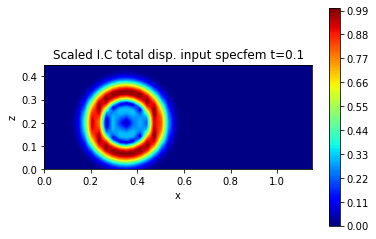

In [14]:
################### plots of inputs for sum of the events
fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, np.sqrt(U_ini1x**2+U_ini1z**2).reshape(xx.shape),100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Scaled I.C total disp. input specfem t='+str(t01))
plt.colorbar()
plt.axis('scaled')
plt.savefig('Ini_total_disp_spec_sumEvents.png', dpi=400)
plt.show()
plt.close(fig)

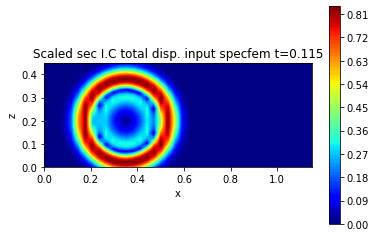

In [15]:
fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, np.sqrt(U_ini2x**2+U_ini2z**2).reshape(xx.shape),100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Scaled sec I.C total disp. input specfem t='+str(round(t02, 4)))
plt.colorbar()
plt.axis('scaled')
plt.savefig('sec_wavefield_input_spec_sumEvents.png', dpi=400)
plt.show()
plt.close(fig)

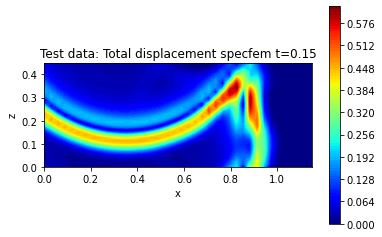

In [16]:
fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, np.sqrt(U_specx**2+U_specz**2).reshape(xx.shape),100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Test data: Total displacement specfem t='+str(round((t_la-t01), 4)))
plt.colorbar()
plt.axis('scaled')
plt.savefig('total_disp_spec_testData_sumEvents.png', dpi=400)
plt.show()
plt.close(fig)

In [17]:
U_ini1x = torch.tensor(U_ini1x, dtype=torch.float32, device=device)
U_ini1z = torch.tensor(U_ini1z, dtype=torch.float32, device=device)
U_ini2x = torch.tensor(U_ini2x, dtype=torch.float32, device=device)
U_ini2z = torch.tensor(U_ini2z, dtype=torch.float32, device=device)

In [18]:
################# ----Z component seismograms
#################input seismograms for the first event
sms = sorted(os.listdir('event1/seismograms/.'))
smsz = [f for f in sms if f[-6]=='Z']#Z cmp seismos
seismo_listz = [np.loadtxt('event1/seismograms/'+f) for f in smsz]#Z cmp seismos

t_spec=-seismo_listz[0][0,0]+seismo_listz[0][:,0]#specfem's time doesn't start from zero for the seismos, so we shift it forward to zero
cut_u=t_spec>t_s#here we include only part of the seismograms from specfem that are within PINNs' training time domain which is [t_st t_m]
cut_l=t_spec<t_st#Cutting the seismograms to only after the time the first snapshot from specfem is used for PINNs
l_su=len(cut_u)-sum(cut_u)#this is the index of the time axis in specfem after which t>t_m
l_sl=sum(cut_l)

l_f=100#subsampling seismograms from specfem
index = np.arange(l_sl,l_su,l_f) #subsampling every l_s time steps from specfem in the training interval
l_sub=len(index)
t_spec_sub=t_spec[index].reshape((-1,1))#subsampled time axis of specfem for the seismograms

t_spec_sub=t_spec_sub-t_spec_sub[0]#shifting the time axis back to zero. length of t_spec_sub must be equal to t_m-t_st

for ii in range(len(seismo_listz)):
    seismo_listz[ii]=seismo_listz[ii][index]

Sz=seismo_listz[0][:,1].reshape(-1,1)
for ii in range(len(seismo_listz)-1):
    Sz=np.concatenate((Sz,seismo_listz[ii+1][:,1].reshape(-1,1)),axis=0)
#################################################################
#######input seismograms for the rest of the events added to the first event
    
for ii in range(n_event-1):
    sms = sorted(os.listdir('event'+str(ii+2)+'/seismograms/.'))
    smsz = [f for f in sms if f[-6]=='Z']#Z cmp seismos
    seismo_listz = [np.loadtxt('event'+str(ii+2)+'/seismograms/'+f) for f in smsz]
    
    for jj in range(len(seismo_listz)):
        seismo_listz[jj]=seismo_listz[jj][index]


    Sze=seismo_listz[0][:,1].reshape(-1,1)
    for jj in range(len(seismo_listz)-1):
       Sze=np.concatenate((Sze,seismo_listz[jj+1][:,1].reshape(-1,1)),axis=0)
       
    Sz +=Sze
###########################################################


Sz=Sz/u_scl #scaling the sum of all seismogram inputs


#X_S is the training collection of input coordinates in space-time for all seismograms
X_S=np.empty([int(np.size(Sz)), 3])

d_s=np.abs((zl_s-z0_s))/(n_seis-1)#the distance between seismometers

for i in range(len(seismo_listz)):
  X_S[i*l_sub:(i+1)*l_sub,]=np.concatenate((ax/Lx*np.ones((l_sub,1),dtype=np.float64), \
                               (z0_s-i*d_s)/Lz*np.ones((l_sub,1),dtype=np.float64),t_spec_sub),axis=1)
################# ----X component seismograms
#################input seismograms for the first event
sms = sorted(os.listdir('event1/seismograms/.'))
smsx = [f for f in sms if f[-6]=='X']#X cmp seismos
seismo_listx = [np.loadtxt('event1/seismograms/'+f) for f in smsx]#X cmp seismos

for ii in range(len(seismo_listx)):
    seismo_listx[ii]=seismo_listx[ii][index]

Sx=seismo_listx[0][:,1].reshape(-1,1)
for ii in range(len(seismo_listx)-1):
    Sx=np.concatenate((Sx,seismo_listx[ii+1][:,1].reshape(-1,1)),axis=0)

#################################################################
#######input seismograms for the rest of the events added to the first event
    
for ii in range(n_event-1):
    sms = sorted(os.listdir('event'+str(ii+2)+'/seismograms/.'))
    smsx = [f for f in sms if f[-6]=='X']#X cmp seismos
    seismo_listx = [np.loadtxt('event'+str(ii+2)+'/seismograms/'+f) for f in smsx]
    
    for jj in range(len(seismo_listx)):
        seismo_listx[jj]=seismo_listx[jj][index]



    Sxe=seismo_listx[0][:,1].reshape(-1,1)
    for jj in range(len(seismo_listx)-1):
       Sxe=np.concatenate((Sxe,seismo_listx[jj+1][:,1].reshape(-1,1)),axis=0)
       
    Sx +=Sxe

Sx=Sx/u_scl #scaling the sum of all seismogram inputs

In [19]:
X_S = torch.tensor(X_S, dtype=torch.float32, requires_grad=True, device=device)
Sx = torch.tensor(Sx, dtype=torch.float32, device=device)
Sz = torch.tensor(Sz, dtype=torch.float32, device=device)

In [20]:
####  BCs: Free stress on top and no BC for other sides (absorbing)
bcxn=100
bctn=50
x_vec = np.random.rand(bcxn,1)*ax/Lx
t_vec = np.random.rand(bctn,1)*(t_m-t_st)
xxb, ttb = np.meshgrid(x_vec, t_vec)
X_BC_t = np.concatenate((xxb.reshape((-1,1)),az/Lz*np.ones((xxb.reshape((-1,1)).shape[0],1)),ttb.reshape((-1,1))),axis=1)

In [21]:
X_BC_t = torch.tensor(X_BC_t, dtype=torch.float32, requires_grad=True, device=device)

In [22]:
def loss_pde():
    x, z, t = X_pde[:, 0:1], X_pde[:, 1:2], X_pde[:, 2:3]
    eq_ = eq(x, z, t)
    loss_pde_ = torch.mean(eq_**2)
    return loss_pde_

In [23]:
def loss_init_disp1():
    x, z, t = X_init1[:, 0:1], X_init1[:, 1:2], X_init1[:, 2:3]
    ux_, uz_ = u(x, z, t)
    loss_init_disp1_ = torch.mean(torch.square(ux_ - U_ini1x)) + torch.mean(torch.square(uz_ - U_ini1z))
    return loss_init_disp1_

def loss_init_disp2():
    x, z, t = X_init2[:, 0:1], X_init2[:, 1:2], X_init2[:, 2:3]
    ux_, uz_ = u(x, z, t)
    loss_init_disp2_ = torch.mean(torch.square(ux_ - U_ini2x)) + torch.mean(torch.square(uz_ - U_ini2z))
    return loss_init_disp2_

In [24]:
def loss_seism():
    x, z, t = X_S[:, 0:1], X_S[:, 1:2], X_S[:, 2:3]
    ux_, uz_ = u(x, z, t)
    loss_seism_ = torch.mean(torch.square(ux_ - Sx)) + torch.mean(torch.square(uz_ - Sz))
    return loss_seism_

In [25]:
def loss_BC():
    x, z, t = X_BC_t[:, 0:1], X_BC_t[:, 1:2], X_BC_t[:, 2:3]
    P_ = P(x, z, t)
    loss_BC_ = torch.mean(torch.square(P_))
    return loss_BC_

In [26]:
def loss():
    loss_pde_val = loss_pde()
    loss_init_disp1_val = loss_init_disp1()
    loss_init_disp2_val = loss_init_disp2()
    loss_seism_val = loss_seism()
    loss_BC_val = loss_BC()
    loss_val = 1e-1*loss_pde_val + loss_init_disp1_val + loss_init_disp2_val + loss_seism_val + 1e-1*loss_BC_val
    return loss_val, loss_pde_val, loss_init_disp1_val, loss_init_disp2_val, loss_seism_val, loss_BC_val

In [27]:
all_params = chain(neural_net.fnn.parameters(), neural_net0.fnn.parameters())
optimizer = torch.optim.Adam(all_params, lr=learning_rate)

In [28]:
xx0, zz0 = xx.reshape((-1,1)), zz.reshape((-1,1)) 

In [29]:
X_eval01=np.concatenate((xx0,zz0,0*np.ones((xx0.shape[0],1))),axis=1)#evaluating PINNs at time=0
X_eval02=np.concatenate((xx0,zz0,(t02-t01)*np.ones((xx0.shape[0],1))),axis=1)#evaluating PINNs at time when the second input from specfem is provided
X_evalt=np.concatenate((xx0,zz0,(t_la-t01)*np.ones((xx0.shape[0],1))),axis=1)#evaluating PINNs at a later time>0
X_eval01 = torch.tensor(X_eval01, dtype=torch.float32, device=device)
X_eval02 = torch.tensor(X_eval02, dtype=torch.float32, device=device)
X_evalt = torch.tensor(X_evalt, dtype=torch.float32, device=device)

In [30]:
# True acoustic wavespeed
alpha_true0 = alpha_true(X_eval01[:, 0:1], X_eval01[:, 1:2]).reshape(xx.shape).detach().cpu().numpy()

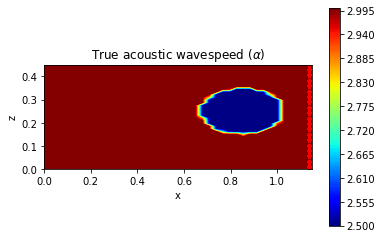

In [31]:
fig = plt.figure()
plt.contourf(Lx*xx, Lz*zz, alpha_true0.reshape((xx.shape)), 100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'True acoustic wavespeed ($\alpha$)')
plt.colorbar()
plt.axis('scaled')
plt.plot(Lx*0.99*X_S.detach().cpu().numpy()[:,0],Lz*X_S.detach().cpu().numpy()[:,1],'r*',markersize=5)
plt.savefig('True_wavespeed.png', dpi=400)
plt.show()
plt.close(fig)

In [32]:
# Initial guess wavespeed
alpha_plot = alpha(X_eval01[:, 0:1], X_eval01[:, 1:2]).reshape(xx.shape).detach().cpu().numpy()

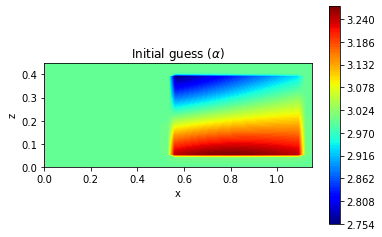

In [33]:
fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, alpha_plot.reshape((xx.shape)), 100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'Initial guess ($\alpha$)')
plt.colorbar()
plt.axis('scaled')
plt.savefig('Ini_guess_wavespeed.png', dpi=400)
plt.show()
plt.close(fig)

In [34]:
# Train
start = timeit.default_timer()
for epoch in range(num_epoch):
    optimizer.zero_grad()
    loss_val, loss_pde_val, loss_init_disp1_val, loss_init_disp2_val, loss_seism_val, loss_BC_val = loss()
    loss_val.backward()
    optimizer.step()
    if epoch % 200 == 0:
        stop = timeit.default_timer()
        print('Time: ', stop - start)
        print('Epoch: ', epoch, ', Loss: ', loss_val.item(), ', Loss_pde: ', loss_pde_val.item(), ', Loss_init_disp1: ', loss_init_disp1_val.item())
        print(', Loss_init_disp2: ', loss_init_disp2_val.item(),'Loss_seism: ', loss_seism_val.item(),'Loss_stress: ', loss_BC_val.item())

Time:  0.27587356800358975
Epoch:  0 , Loss:  37.42295837402344 , Loss_pde:  211.100341796875 , Loss_init_disp1:  5.793323993682861
, Loss_init_disp2:  5.945038795471191 Loss_seism:  4.319673538208008 Loss_stress:  2.5488855838775635
Time:  8.301058232005744
Epoch:  200 , Loss:  1.013513207435608 , Loss_pde:  6.0075249671936035 , Loss_init_disp1:  0.13250169157981873
, Loss_init_disp2:  0.12631158530712128 Loss_seism:  0.12109272927045822 Loss_stress:  0.32854726910591125
Time:  16.215378413005965
Epoch:  400 , Loss:  0.5713350772857666 , Loss_pde:  2.9485514163970947 , Loss_init_disp1:  0.10070828348398209
, Loss_init_disp2:  0.09444551169872284 Loss_seism:  0.06209615245461464 Loss_stress:  0.1922997534275055
Time:  24.136999858004856
Epoch:  600 , Loss:  0.3690909445285797 , Loss_pde:  1.508100986480713 , Loss_init_disp1:  0.0874062031507492
, Loss_init_disp2:  0.08087289333343506 Loss_seism:  0.03915238380432129 Loss_stress:  0.10849349945783615
Time:  32.04507886700594
Epoch:  800

KeyboardInterrupt: 

In [35]:
alpha_inv = alpha(X_eval01[:, 0:1], X_eval01[:, 1:2]).reshape(xx.shape).detach().cpu().numpy()

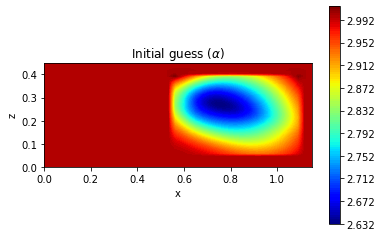

In [36]:
fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, alpha_inv.reshape((xx.shape)), 100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'Initial guess ($\alpha$)')
plt.colorbar()
plt.axis('scaled')
plt.show()
plt.close(fig)

In [37]:
x, z, t = X_init1[:, 0:1], X_init1[:, 1:2], X_init1[:, 2:3]
ux_, uz_ = u(x, z, t)

In [38]:
ux_ = ux_.detach().cpu().numpy()
uz_ = uz_.detach().cpu().numpy()

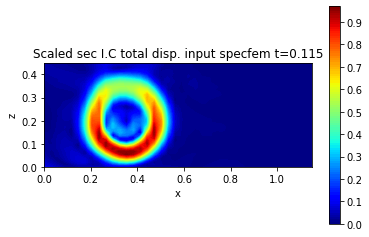

In [40]:
fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, np.sqrt(ux_**2+uz_**2).reshape(xx.shape),100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Scaled sec I.C total disp. input specfem t='+str(round(t02, 4)))
plt.colorbar()
plt.axis('scaled')
plt.show()
plt.close(fig)